## About

We want to discover heat conductivity that is temperature-dependent from synthetic data. More information is available in `ToDo.ipynb`.

## Overview

### Questions to answer



- Can we figure out heat conductivity or mobility from observational data?
- This is an exploratory study for mobility discovery for Cahn-Hilliard equation.

### Outline of exploration

1. Generate synthetic observational data 
   1. Simulate heat equation with the mobility functions to detect.
2. Construct dictionary for sparse learning
   1. Simulate heat equation with basis mobility functions (basis of *trial space* or *approximation space*)
3. Conduct sparse learning
4. Examine performance

### Settings


- We confine our discussions to one spatial dimension as an exploratory work.

### Numerical tools

#### Fourier collocation method (FCM)



- This study build upon FCM, which is the workhorse for data generation.
- We borrow numerical tools of FCM that have been built from Jea-Hyun Park's previous work on phase field models.


#### Precondition gradient descent method (PGD)


- The nonlinear solver involves PGD along with FCM.
- This is based on Jea-Hyun Park's previous work on phase field models.

## Heat equation 



$$
u_t = \frac{d}{dx} (M(u) \frac{d}{dx} u),
\\
$$

supplemented with periodic boundary conditions on a square domain $\Omega$,  where $M:\mathbb{R}\to\mathbb{R}$ is called *heat conductivity* (or *mobility* in the evolution of material context).


## Simulation (synthetic data generation)



### 1. Computation set up

#### Loading/setting packages

In [542]:
# Package path setting
# from pathlib import Path
# import sys
# path_fcm = Path('./NumTools/')
# sys.path.append(str(path_fcm)) 
# PyTorch setting
import torch as tc
tc.set_default_dtype(tc.float64)
print("PyTorch default data type is set to: float64 and complex128")
dev = 'cuda:0' if tc.cuda.is_available() else 'cpu'
print("Main computing device is set to: ", dev)

# Plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 16})

# Personal packages (FCM: Fourier collocation method)
from FCM import fcm
from OptimizationTools.descent_methods import pgd
from LogTools import logger
from VisTools import plotting

PyTorch default data type is set to: float64 and complex128
Main computing device is set to:  cpu


#### PDE and numerical set up

In [543]:
#%% Parameter setting
# Numerical setting
NN = 2**7 # spatial resoltuion
dt = 2e-4 # time step size
tau = dt # an alias for time step size

# PDE setting

# FORMAT: last lambda fn is the true mobility, 
# the rest are the basis (training) functions
Mobs = [lambda u: 1.0, 
        lambda u: 1.0 + 0.3*u, 
        lambda u: 1.0 - 0.3*u*u, 
        lambda u: 1.0 + 0.3*u**3,
        lambda u: 1.0 - 0.3*u**4,
        lambda u: 1.0 + 0.3*u**5,
        lambda u: 1.0 - 0.3*u**6,
        lambda u: 1.0 + 0.1*u + 0.2*u**5, # Test function
        # lambda u: 1.0 + 0.1*u - 0.3*u*u,
        ]

TT = 0.004       # final time
LL = 1          # spatial domain size

#%% Computation preparations
KK = int(TT/dt) # number of time steps
assert KK*dt == TT, "TT/dt must be an integer."

# spatial grid
hh = LL/NN      # grid spacing
xx = tc.arange(0, LL, hh, device=dev)           
assert len(xx) == NN, "The number of spatial grid points is wrong."

# time grid
tt = tc.arange(0, TT + dt, dt, device=dev).reshape(-1, 1) 
assert len(tt) == KK + 1, "The number of time grid points is wrong."

# initialize the FCM module for 1D (eigenvlaues of fcm)
fcm_eigs1 = fcm.ini_1D(LL, NN) 

#%% Initial condition
# set initial condition
aa = 2.
CC = 2*tc.pi/LL
AA = aa*CC
ic = tc.sin(AA*xx) # initial condition


### 2. Diagnostics

#### True solution setting if available

True solution is available only for constant conductivity 1.

In [544]:
true_sol_available = True

true_sol_fn = lambda t, x: tc.exp(-AA*AA*t)*tc.sin(AA*x)
true_sol = true_sol_fn(tt, xx)

#### Plot initial condition

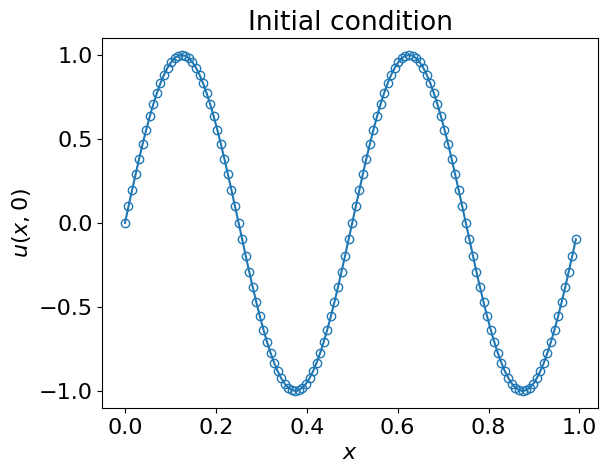

In [545]:
#%% plot initial condition
fig, ax = plt.subplots()
if dev == 'cuda:0': 
    xx_ = xx.cpu()
    ic_ = ic.cpu()
else:
    xx_ = xx
    ic_ = ic
# """
ax.plot(xx_, ic_, 'o-', mfc='none', label=r"$u(x,0)$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u(x,0)$")
ax.set_title("Initial condition")

plt.show()



### 3. Main computation

#### Simulate heat equation with each conductivity

**Note**

- If PDE solver struggles, consider tuning
  - step size: `get_step_size = lambda vv, dd, sz_par: 0.04` to some smaller number
  - max iter: `PGDSetting = {'max_iter': 200` to some larger number
  - time step size: `dt` smaller
  - Final time: `TT = 0.004` smaller

In [546]:
# storage variables
logs = []
num_sols = []

# `mm` is the number of basis functions:
#   last mobility is what we want to detect, hence '- 1'
mm = len(Mobs) - 1 

for m in range(mm+1):
    # take each mobility function (basis and then one to detect)
    Mob = Mobs[m]

#%% Numerical solver setting: PGD
    # PGD 1. Gradient operator
    grad_par = {'fcm_eigs1': fcm_eigs1, 'tau': tau, 'uuk': ic}
    get_grad = lambda vv, grad_par: - tau * fcm.Dx((grad_par['MM'] * fcm.Dx(vv, grad_par['fcm_eigs1'])), grad_par['fcm_eigs1']) + vv - grad_par['uuk']
    grad = {'get_grad': get_grad, 'grad_par': grad_par}

    # PGD 2. Preconditioner (FOR NOW NO PRECONDITIONER)
    prec_par = {'fcm_eigs1': fcm_eigs1, 'gamma': 1., 'tau': tau}
    """Proper preconditioner to be debugged
    # invert_prec = lambda rr, prec_par: fcm.inv_Dxx(rr, fcm_eigs1, coeff=(-prec_par['gamma']*prec_par['tau']))
    """
    #       No proconditioner for now (identity)
    invert_prec = lambda rr, prec_par: rr
    prec = {'invert_prec': invert_prec, 'prec_par': prec_par}

    # PGD 3. Other PGD setting 
    #  3.1. step size (FOR NOW CONSTANT STEP SIZE)
    sz_par = {'grad_par': grad_par, 'prec_par': prec_par}
    #       constant step size for now
    get_step_size = lambda vv, dd, sz_par: 0.04
    """Optimal step size to be debugged
    # get_step_size = lambda vv, dd, sz_par: (tc.sum((sz_par['grad_par']['uuk'] - vv) * dd)*hh - sz_par['grad_par']['tau']*fcm.H1Mz_ip(vv, dd, sz_par['grad_par']['MM'], fcm_eigs1))/(tc.sum(dd*dd)*hh - sz_par['grad_par']['tau']*fcm.H1Mz_ip(dd, dd, sz_par['grad_par']['MM'], fcm_eigs1))
    """
    #  3.2. residual (for stopping criteria, not as negative gradient)
    get_residual = lambda dd, rr, PGDSetting: tc.sum(dd*rr) * PGDSetting['hh']
    PGDSetting = {'max_iter': 200, 'Tol': 1e-8, 
                'upTol': 1e+8, 
                'get_residual': get_residual,
                'get_step_size': get_step_size, 'sz_par': sz_par,
                'hh': hh, 'NN': NN, 'dev': dev}

    #%% Computational log setting for the current mobility
    log = []
    log_par = {}

    #%% Computation of the numerical solution
    uu = ic # initial condition
    num_sol = tc.zeros((KK + 1, NN), device=dev) 
    num_sol[0, :] = uu

    for kk in range(KK):

        # update iterate and mobility
        grad_par.update({'MM': Mob(uu), 'uuk': uu})

        # compute pgd solution
        uup, PGD_log = pgd(uu, grad, prec, PGDSetting) # uup: uu_{k+1}

        # record solution and log
        num_sol[kk+1, :] = uup
        log.append(PGD_log)

        uu = uup

    #%% Post-processing
    log = logger.reorganize_log(log)

    #%% Store results
    logs.append(log)
    num_sols.append(num_sol)


### 4. Report/Plot

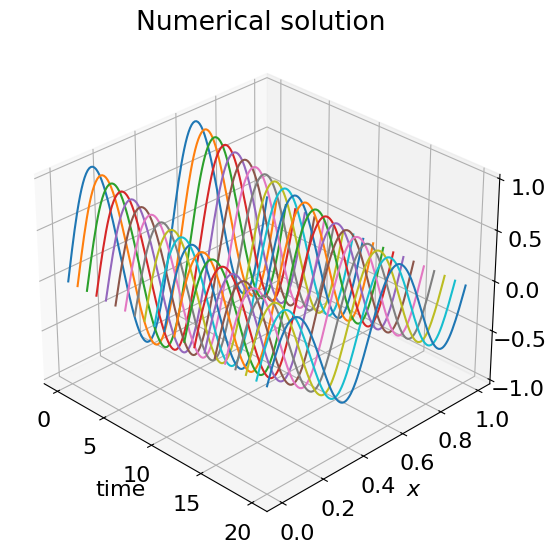

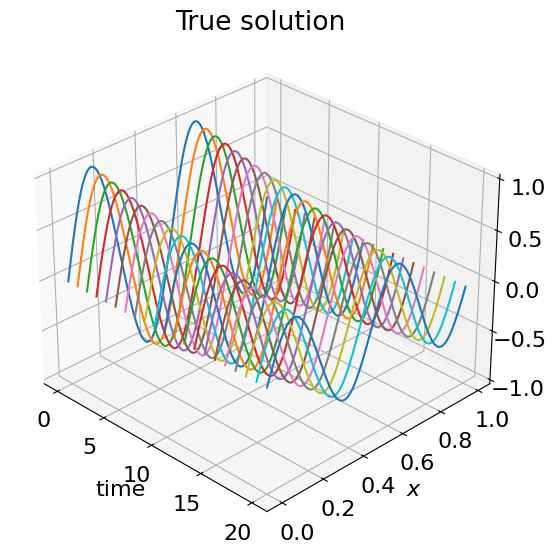

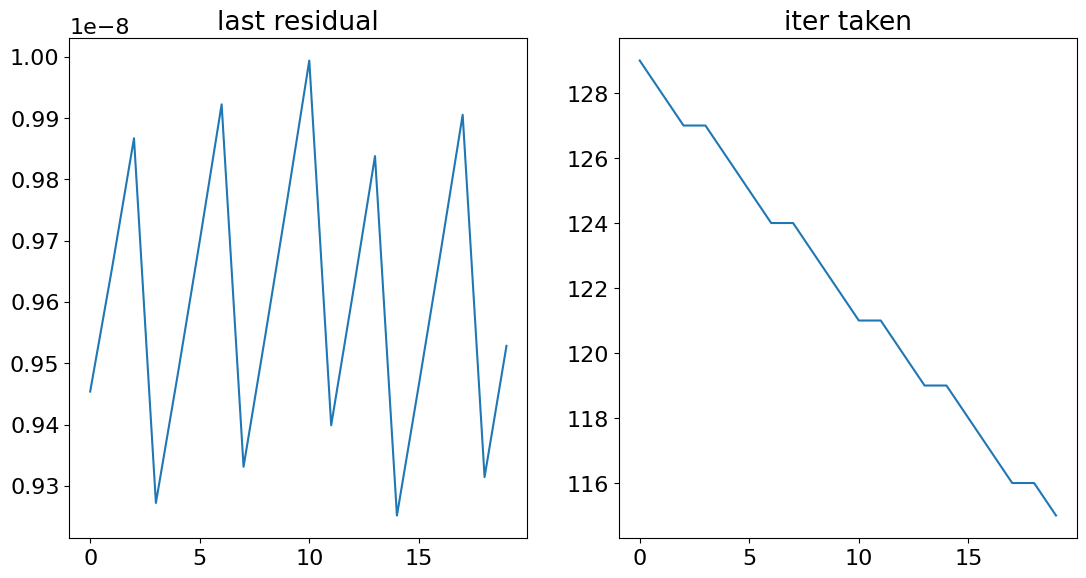

In [547]:
#%% plot numerical solution

axs = [] # in case of multiple figures e.g. true and numerical solutions

fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5), subplot_kw={'projection':'3d'})

for i in range(KK+1):
    if dev == 'cuda:0': 
        num_sol_ = num_sol[i, :].cpu()
    elif dev == 'cpu':
        num_sol_ = num_sol[i, :]
    ax.plot(i * tc.ones_like(xx_), xx_, num_sol_)

ax.set_title('Numerical solution')

axs.append(ax)

#%% plot true solution
if true_sol_available:
    fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5), subplot_kw={'projection':'3d'})
    
    for i in range(KK+1):
        if dev == 'cuda:0':
            true_sol_ = true_sol[i, :].cpu()
        elif dev == 'cpu':
            true_sol_ = true_sol[i, :]
        ax.plot(i * tc.ones_like(xx_), xx_, true_sol_)
    
    ax.set_title('True solution')
    axs.append(ax)

# Change the angle of projection
for j in range(len(axs)):
    axs[j].set_xlabel('time')
    axs[j].set_ylabel('$x$')
    axs[j].view_init(elev=30, azim=-45)

plt.show()

#%% Diagnostic plot
fig, ax = plt.subplots(1,2, figsize=(13, 6.5))

plotting.seqs(ax[0], log['last_residual'], param_dict={'title': 'last residual'})
plotting.seqs(ax[1], log['iter_taken'], param_dict={'title': 'iter taken'})

plt.show()


### 4.5 Some minor thing

In [548]:
import inspect

# get the source str for Mobs: lambda function cannot be pickled
Mobs_str = inspect.getsource(Mobs[0])
print(Mobs_str)

Mobs = [lambda u: 1.0, 
        lambda u: 1.0 + 0.3*u, 
        lambda u: 1.0 - 0.3*u*u, 
        lambda u: 1.0 + 0.3*u**3,
        lambda u: 1.0 - 0.3*u**4,
        lambda u: 1.0 + 0.3*u**5,
        lambda u: 1.0 - 0.3*u**6,
        lambda u: 1.0 + 0.1*u + 0.2*u**5, # Test function
        # lambda u: 1.0 + 0.1*u - 0.3*u*u,
        ]



### 5. (Only when necessary) Save/load the result

#### Save as a file

In [549]:
import pickle

with open('trajs.pkl', 'wb') as f:
    pickle.dump([num_sols, logs, Mobs_str], f)


#### Get data from file

In [550]:
import pickle

with open('trajs.pkl', 'rb') as f:
    num_sols, logs, Mobs_str = pickle.load(f)


## Sparse learning

### Warm-up: Lease square

#### Construct dictionary matrix and rhs vector

In [551]:
AA = tc.zeros(KK*NN, mm, device=dev)
bb = tc.zeros((KK, NN), device=dev)
tmp = tc.zeros((KK, NN), device=dev)

# loop: for each mobility function
for i in range(len(Mobs)):

    Mob = Mobs[i]
    num_sol = num_sols[i]

    # Stacking rhs Dx(M(u)Dx(u)) as a column vector (= (u_K+1 - u_k)/tau) 
    # 1. stack for each time step
    for kk in range(KK):
        tmp[kk, :] = num_sol[kk+1] - num_sol[kk]
    
    # 2. reshape to a column vector
    if i == mm:
        bb = tmp.reshape(-1)
    else:
        AA[:, i] = tmp.reshape(-1)

# shape check
print(AA.shape)
print(bb.shape)

torch.Size([2560, 7])
torch.Size([2560])


In [552]:
print(Mobs_str)

Mobs = [lambda u: 1.0, 
        lambda u: 1.0 + 0.3*u, 
        lambda u: 1.0 - 0.3*u*u, 
        lambda u: 1.0 + 0.3*u**3,
        lambda u: 1.0 - 0.3*u**4,
        lambda u: 1.0 + 0.3*u**5,
        lambda u: 1.0 - 0.3*u**6,
        lambda u: 1.0 + 0.1*u + 0.2*u**5, # Test function
        # lambda u: 1.0 + 0.1*u - 0.3*u*u,
        ]



#### Least square solution and exact mobility

In [553]:
#%% Least square solution
x_LS = tc.linalg.lstsq(AA, bb).solution
print(f"Least Squares: {x_LS}")

#%% true solution
# name: Vandermonde matrix due to the brute force nature
"""Vand = [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0.3, 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0.3, 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0.3, 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., -0.3, 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.3, 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., -0.3, 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.3, 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., -0.3, 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.3, 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0.3]]


Vand = tc.tensor(Vand, device=dev)
Vand = Vand.T

# rhs must match the coefficients of the chosen mobility to be detected
rhs = tc.tensor([1., 0.1, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.], device=dev)
"""
#%% true solution
# name: Vandermonde matrix due to the brute force nature
Vand = [[1., 0., 0., 0., 0., 0., 0.],
        [1., 0.3, 0., 0., 0., 0., 0.],
        [1., 0., -0.3, 0., 0., 0., 0.],
        [1., 0., 0., 0.3, 0., 0., 0.],
        [1., 0., 0., 0., -0.3, 0., 0.],
        [1., 0., 0., 0., 0., 0.3, 0.],
        [1., 0., 0., 0., 0., 0., -0.3]]
Vand = tc.tensor(Vand, device=dev)
Vand = Vand.T

# rhs must match the coefficients of the chosen mobility to be detected
rhs = tc.tensor([1., 0.1, 0., 0., 0., 0.2, 0.], device=dev)

x_true = tc.linalg.solve(Vand, rhs)

print(x_true)

print(Mobs_str)
x_true = tc.linalg.solve(Vand, rhs)

print(f"The true solution: {x_true}")

print(Mobs_str)
print(AA.shape)

Least Squares: tensor([ 0.0036,  0.3293, -0.0812,  0.0091,  0.2112,  0.6638, -0.1365])
tensor([-1.1102e-16,  3.3333e-01, -0.0000e+00,  0.0000e+00, -0.0000e+00,
         6.6667e-01, -0.0000e+00])
Mobs = [lambda u: 1.0, 
        lambda u: 1.0 + 0.3*u, 
        lambda u: 1.0 - 0.3*u*u, 
        lambda u: 1.0 + 0.3*u**3,
        lambda u: 1.0 - 0.3*u**4,
        lambda u: 1.0 + 0.3*u**5,
        lambda u: 1.0 - 0.3*u**6,
        lambda u: 1.0 + 0.1*u + 0.2*u**5, # Test function
        # lambda u: 1.0 + 0.1*u - 0.3*u*u,
        ]

The true solution: tensor([-1.1102e-16,  3.3333e-01, -0.0000e+00,  0.0000e+00, -0.0000e+00,
         6.6667e-01, -0.0000e+00])
Mobs = [lambda u: 1.0, 
        lambda u: 1.0 + 0.3*u, 
        lambda u: 1.0 - 0.3*u*u, 
        lambda u: 1.0 + 0.3*u**3,
        lambda u: 1.0 - 0.3*u**4,
        lambda u: 1.0 + 0.3*u**5,
        lambda u: 1.0 - 0.3*u**6,
        lambda u: 1.0 + 0.1*u + 0.2*u**5, # Test function
        # lambda u: 1.0 + 0.1*u - 0.3*u*u,
        ]

to

## Sequential Thresholded Least Squares

In [554]:
import torch as tc

def perform_STLS(A, x_initial, target, threshold, max_iter):
    '''
    STLS algorithm to add sparsity to x by using threshold and max_iter, and checks if the prior iterated xi is equal to the new xi
    params:
    - A: Library matrix of basis functions for each column in the matrix
    - x_initial: xi_LS tensor/vector obtained from performing Least Squares
    - target: target matrix (i.e., xyz_dot)
    - threshold: threshold value - usually 0.1
    - max_iter: maximum number of iterations - usually 100, but the algorithm will break if the prior iterated xi is equal to the new xi
    '''
    # Initialize x and iteration count
    x = x_initial.clone()  # make a copy of x_initial
    iter_count = 0
        
    while iter_count < max_iter:
        # Store a copy of the x from the previous iteration
        x_prev = x.clone()
        
        # Step 1: Threshold x
        small_indices = tc.abs(x) < threshold
        x[small_indices] = 0 # set these indices to 0
        
        # Step 2: Remove the corresponding columns in A
        non_zero_indices = ~small_indices  # Invert the small_indices to get non-zero indices
        A_prime = A[:, non_zero_indices] # remove columns of A, by only keeping nonzero entries

        # Step 3: Solve the least squares problem with the updated A matrix
        x_new = tc.linalg.lstsq(A_prime, target).solution[:A_prime.shape[1]] # This extracts the solution part of the result.
        
        # Step 4: save and update only the non-zero entries in x
        x[non_zero_indices] = x_new.squeeze() # matching up values where non zeros are with our x_new
        
        # check if A has removed all columns
        if A.shape[1] == 0:
            break
        
        # Check for convergence
        if tc.allclose(x, x_prev, atol=threshold):
            break
        
        iter_count += 1
    
    return x

# Example usage
threshold = 0.1
max_iter = 100
x_SLS = perform_STLS(AA, x_LS, bb, threshold, max_iter)
print(x_SLS)
print(x_true)

tensor([0.0000, 0.3310, 0.0000, 0.0000, 0.0000, 0.6695, 0.0000])
tensor([-1.1102e-16,  3.3333e-01, -0.0000e+00,  0.0000e+00, -0.0000e+00,
         6.6667e-01, -0.0000e+00])


## Lasso Model

In [555]:
from sklearn.linear_model import Lasso
# Lasso model

def perform_Lasso(library_matrix, target, alpha, warm_start = True):
    '''
    LASSO function to increase sparsity in the xi matrix when calculating (basis_func_matrix @ Xi) = target
    params:
    - library_matrix: This is the design matrix created from basis functions
    - target: this is our b matrix we are trying to get "close" to when solving for xi
    - alpha: parameter to increase or decrease sparsity (increasing the value adds sparsity)
    - warm_start: usually we leave true but can turn off
    '''
    model = Lasso(alpha = alpha, fit_intercept = False, max_iter = 10000, warm_start = True)
    model.fit(library_matrix, target)
    x = model.coef_
    return x

# Running lasso function for each column of xyz_dot
alpha = 0.00015
x_LASS = perform_Lasso(AA, bb, alpha)
print(x_LASS.shape)
print(f"True: {x_true}")
print(f"Lasso: {x_LASS}")
print(f"Least Square: {x_LS}")

(7,)
True: tensor([-1.1102e-16,  3.3333e-01, -0.0000e+00,  0.0000e+00, -0.0000e+00,
         6.6667e-01, -0.0000e+00])
Lasso: [0.         0.15739849 0.         0.29729411 0.         0.
 0.        ]
Least Square: tensor([ 0.0036,  0.3293, -0.0812,  0.0091,  0.2112,  0.6638, -0.1365])


## Elastic Net Model

In [556]:
from sklearn.linear_model import ElasticNetCV

def perform_enet_cv(A, b, l1_ratio=[.1, .3, .7, .9, .95, .99, 1], cv=5):
    """
    Returns a solution to Ax=b by using cross validation elastic net
    input:
    A: Matrix containing information
    b: solution vector we want to find an approximation s.t. A@x=b
    l1_ratio: list of different penalties to try out
    cv: Cross validation with k folds and k = 5

    return:
    x: solution to Ax=b
    model.alpha_: Best alpha value
    model.l1_ratio_: best penalty value
    """
    model = ElasticNetCV(l1_ratio=l1_ratio, cv=cv, fit_intercept=True) # create model
    model.fit(A, b) # fit model to training
    x = model.coef_ # return coefficients 
    return x, model.alpha_, model.l1_ratio_

x_net_cv, alpha_best, l1_best = perform_enet_cv(AA, bb, cv=5)
x_net_cv = tc.tensor(x_net_cv, device=dev)

print(x_net_cv)
print(f"Best alpha: {alpha_best}")
print(f"Best l1_ratio: {l1_best}")


tensor([0.1320, 0.2576, 0.0216, 0.5083, 0.0000, 0.0809, 0.0000])
Best alpha: 2.782163184371608e-07
Best l1_ratio: 0.99


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.451e-05, tolerance: 7.044e-05
  model = cd_fast.enet_coordinate_descent(


# SR3 From SINDY

In [557]:
import pysindy as ps

# Assuming AA and bb are ready to use
library_matrix = AA  # prepared library matrix
target_vector = bb  # target vector or b
degree = 1
feature_library = ps.PolynomialLibrary(degree=degree)
# Define the SR3 optimizer with chosen parameters
optimizer = ps.optimizers.SR3(threshold=0.001, max_iter=10000, tol=1e-5)

# Initialize and fit the SINDy model with the specified feature library and optimizer
model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
model.fit(library_matrix, t=dt, x_dot=target_vector)
x_sr3 = tc.tensor(model.coefficients(), device=dev)

## Plotting Differences in values

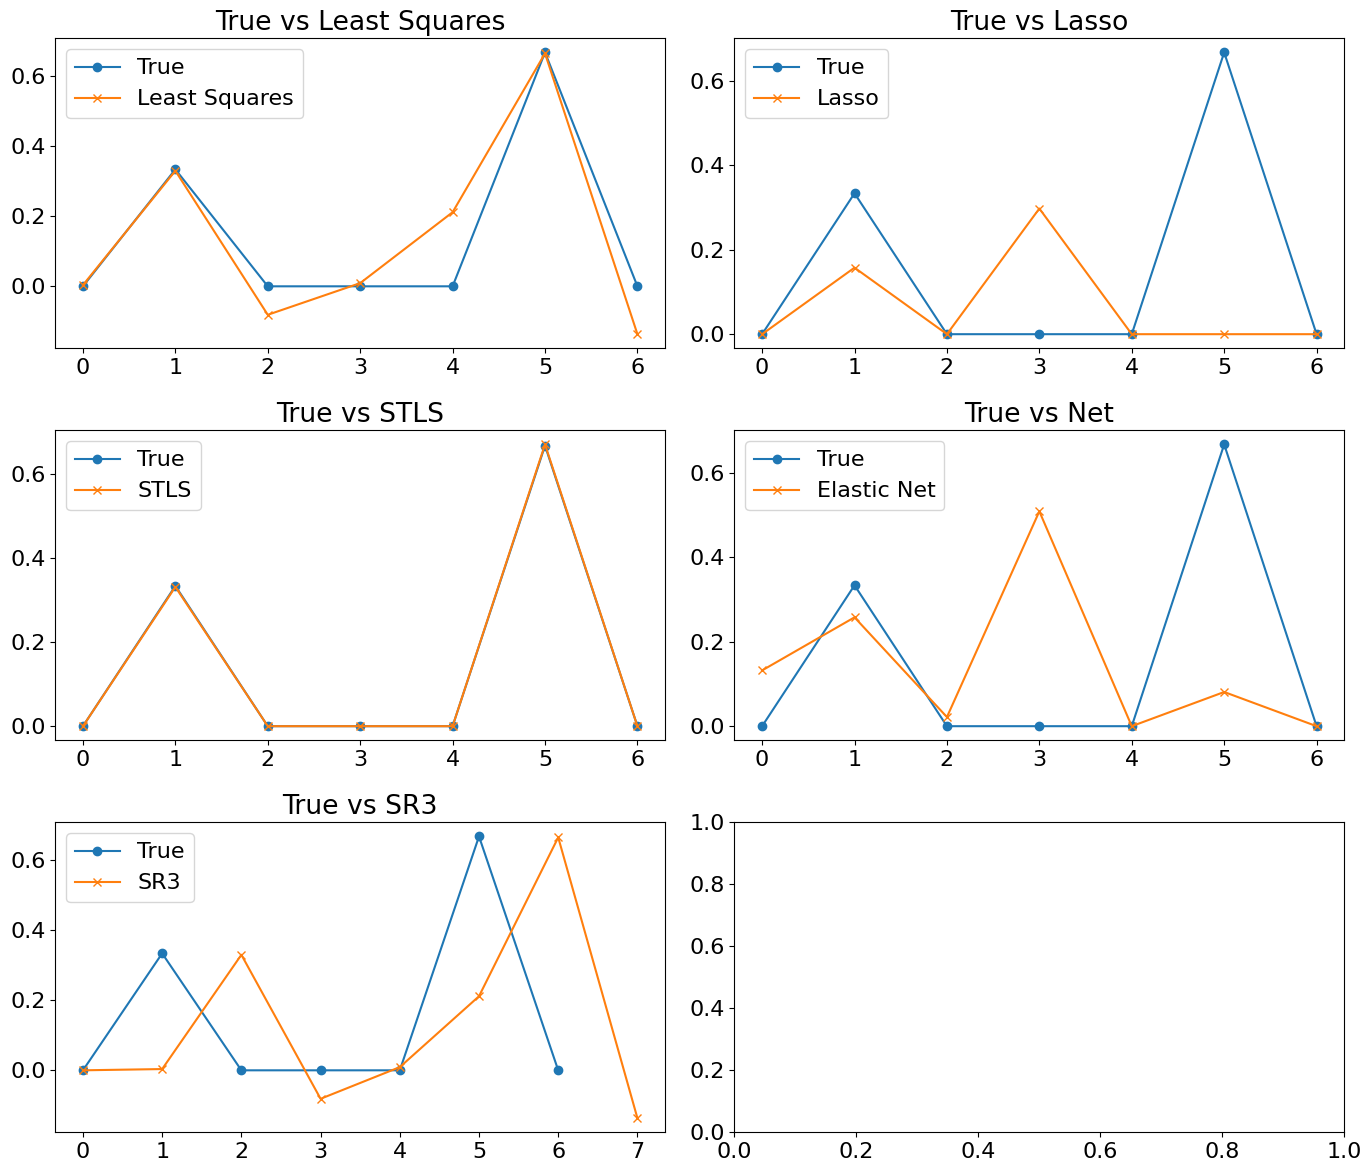

In [558]:
import matplotlib.pyplot as plt

# Ensure all tensors are squeezed to 1D arrays
x_true = x_true.squeeze()
x_ls = x_LS.squeeze()
x_stls = x_SLS.squeeze()
x_lasso = x_LASS.squeeze()
x_net = x_net_cv.squeeze()
x_sr3 = x_sr3.squeeze()  # Assuming x_sr3 is your SR3 result

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))  # Adjusted for an additional row

# Plot for Least Squares
axs[0, 0].plot(x_true, label='True', marker='o')
axs[0, 0].plot(x_ls, label='Least Squares', marker='x')
axs[0, 0].set_title('True vs Least Squares')
axs[0, 0].legend()

# Plot for STLS
axs[1, 0].plot(x_true, label='True', marker='o')
axs[1, 0].plot(x_stls, label='STLS', marker='x')
axs[1, 0].set_title('True vs STLS')
axs[1, 0].legend()

# Plot for Lasso
axs[0, 1].plot(x_true, label='True', marker='o')
axs[0, 1].plot(x_lasso, label='Lasso', marker='x')
axs[0, 1].set_title('True vs Lasso')
axs[0, 1].legend()

# Plot for Elastic Net
axs[1, 1].plot(x_true, label='True', marker='o')
axs[1, 1].plot(x_net, label='Elastic Net', marker='x')
axs[1, 1].set_title('True vs Net')
axs[1, 1].legend()

# Additional Plot for SR3
axs[2, 0].plot(x_true, label='True', marker='o')  # Adjust your indexing as needed
axs[2, 0].plot(x_sr3, label='SR3', marker='x')
axs[2, 0].set_title('True vs SR3')
axs[2, 0].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Kept just in case (All obsolete)

### plotting true solution at initial time

In [559]:
if true_sol_available != True:
    pass
else:
    # Exact solution
    true_sol_fn = lambda t, x: tc.exp(-AA*AA*t)*tc.sin(AA*x)
    true_sol = true_sol_fn(tt, xx)
    
    # plot exact solution
    if dev == 'cuda:0': 
        sol_ = true_sol[0,:].cpu()
    ax.plot(xx_, sol_, 'm--', label=r"$u(x,t)$")
    # """


RuntimeError: The size of tensor a (2560) must match the size of tensor b (21) at non-singleton dimension 0

### Approach 2 (obsolete): Fitting norm profiles

- This didn't work well. (currently obsolete)
- Maybe in the future, this may do some supproting/supplemental roles to enhance the main sparse learning result.

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(15, 5))

nrm_prof = tc.zeros((mm + 1, KK), device=dev)
nrm_prof_rhs = tc.zeros(KK, device=dev)
for m in range(mm + 1):
    for kk in range(1, KK+1):
        uu = num_sols[m][kk]
        # uu_pre = num_sols[m][kk-1]
        MM = Mob(uu)
        nrm_prof[m, kk-1] = fcm.H1Mz_ip(uu, uu, MM, fcm_eigs1)

    plotting.seqs(ax[m], nrm_prof[m].cpu(), param_dict={'title': 'H1Mz norm ' + str(m+1)})


##### Plot: Difference between numerical solutions at the final time with different conductivities

In [ ]:
from itertools import combinations

comb = combinations(range(mm), 2)

fig, ax = plt.subplots(1,3, figsize=(15, 5))

k = 0
for i, j in comb:
    plotting.seqs(ax[k], nrm_prof[i].cpu() - nrm_prof[j].cpu(), param_dict={'title': 'Num sol ' + str(i+1) + ' - ' + str(j+1)})
    k += 1


#### Approach 2 Least square solution

In [ ]:
AA = tc.stack(tuple([nrm_prof[i] for i in range(mm)]))
AA = AA.T

bb = nrm_prof[-1]

print(AA.shape, bb.shape)

x = tc.linalg.lstsq(AA, bb).solution

print(x)
